### Company XYZ is a major credit card company. It has information about all the transactions that users make with their credit card. Your boss asks you to do the following:

#### (1) Your boss wants to identify those users that in your dataset never went above the monthly credit card limit (calendar month). The goal of this is to increase their limit automatically. Can you send him the list of Ids?

#### (2) On the other hand, she wants you to implement an algorithm that as soon as a user goes above her monthly limit, it triggers an alert so that the user can be notified about that. We assume here that at the beginning of a new month, user total money spent gets reset to zero (i.e., she pays the card fully at the end of each month). Build a function that for each day, returns a list of users who went above their credit card monthly limit on that day.

#### (3) Finally, your boss is very concerned about frauds cause they are a huge cost for credit card companies. She wants you to implement an unsupervised algorithm that returns all transactions that seem unusual and are worth being investigated further.

### Load the package would be used

In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 10)
pd.set_option("display.width", 350)

import zipcodes

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


### Read in the data set

In [2]:
cc_info = pd.read_csv("../Datasets/credit_card/cc_info.csv")
transactions = pd.read_csv("../Datasets/credit_card/transactions.csv")

### Look into dataset

In [3]:
print(cc_info.shape)
print(transactions.shape)

print(cc_info.head)
print(transactions.head)

print(cc_info.info)
print(transactions.info)

print(len(cc_info["credit_card"]) == len(pd.unique(cc_info["credit_card"])))
print(len(transactions["credit_card"]) == len(pd.unique(transactions["credit_card"])))

(984, 5)
(294588, 5)
<bound method NDFrame.head of           credit_card        city state  zipcode  credit_card_limit
0    1280981422329509      Dallas    PA    18612               6000
1    9737219864179988     Houston    PA    15342              16000
2    4749889059323202      Auburn    MA     1501              14000
3    9591503562024072     Orlando    WV    26412              18000
4    2095640259001271    New York    NY    10001              20000
..                ...         ...   ...      ...                ...
979  8938296722055540     Houston    PA    15342              36000
980  2756688131944353  Washington    NH     3280              15000
981  5783648852115715  Washington    NH     3280              20000
982  8259854075192493       Omaha    GA    31821              10000
983  1409322756311484     Houston    PA    15342              15000

[984 rows x 5 columns]>
<bound method NDFrame.head of              credit_card                 date  transaction_dollar_amount      

### Data processing

In [4]:
cc_info["longitude"] = 0.00
cc_info["latitude"] = 0.00

for i in range(len(cc_info)):
    ZIP = cc_info["zipcode"].values[i].astype(str)
    if len(ZIP) == 3:
        zipcode = zipcodes.matching("00" + ZIP)   
    if len(ZIP) == 4:
        zipcode = zipcodes.matching("0" + ZIP)   
    else:
        zipcode = zipcodes.matching(ZIP)
    if zipcode != []:
        cc_info["longitude"][i] = float(zipcode[0]["long"])
        cc_info["latitude"][i] = float(zipcode[0]["lat"])

cc_info.head()

<ipython-input-4-897c3756bc40>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cc_info["longitude"][i] = float(zipcode[0]["long"])
<ipython-input-4-897c3756bc40>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cc_info["latitude"][i] = float(zipcode[0]["lat"])


,credit_card,city,state,zipcode,credit_card_limit,longitude,latitude
0,1280981422329509,Dallas,PA,18612,6000,-75.9889,41.3549
1,9737219864179988,Houston,PA,15342,16000,-80.2232,40.2495
2,4749889059323202,Auburn,MA,1501,14000,-71.8461,42.1957
3,9591503562024072,Orlando,WV,26412,18000,-80.5647,38.8891
4,2095640259001271,New York,NY,10001,20000,-73.9961,40.7508


In [5]:
dat = transactions.merge(cc_info, on = "credit_card", how = "left")

print(list(dat.columns))
dat.head()

['credit_card', 'date', 'transaction_dollar_amount', 'Long', 'Lat', 'city', 'state', 'zipcode', 'credit_card_limit', 'longitude', 'latitude']


,credit_card,date,transaction_dollar_amount,Long,Lat,...,state,zipcode,credit_card_limit,longitude,latitude
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370,...,PA,15342,20000,-80.2232,40.2495
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114,...,PA,15342,20000,-80.2232,40.2495
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004,...,PA,15342,20000,-80.2232,40.2495
3,1003715054175576,2015-10-22 19:41:10,136.18,-80.174138,40.290895,...,PA,15342,20000,-80.2232,40.2495
4,1003715054175576,2015-10-26 20:08:22,71.82,-80.238720,40.166719,...,PA,15342,20000,-80.2232,40.2495


In [6]:
dat["date"] = pd.to_datetime(dat["date"])

dat["year"] = dat["date"].apply(lambda X: X.year)
dat["month"] = dat["date"].apply(lambda X: X.month)
dat["day"] = dat["date"].apply(lambda X: X.day)
dat["weekday"] = dat["date"].apply(lambda X: X.dayofweek)
dat["hour"] = dat["date"].apply(lambda X: X.hour)

print(list(dat.columns))
dat.head()

['credit_card', 'date', 'transaction_dollar_amount', 'Long', 'Lat', 'city', 'state', 'zipcode', 'credit_card_limit', 'longitude', 'latitude', 'year', 'month', 'day', 'weekday', 'hour']


,credit_card,date,transaction_dollar_amount,Long,Lat,...,year,month,day,weekday,hour
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370,...,2015,9,11,4,0
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114,...,2015,10,24,5,22
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004,...,2015,10,26,0,18
3,1003715054175576,2015-10-22 19:41:10,136.18,-80.174138,40.290895,...,2015,10,22,3,19
4,1003715054175576,2015-10-26 20:08:22,71.82,-80.238720,40.166719,...,2015,10,26,0,20


#### (1) Your boss wants to identify those users that in your dataset never went above the monthly credit card limit (calendar month). The goal of this is to increase their limit automatically. Can you send him the list of Ids?

##### Step 1: Sum all transaction dollar amount group by each credit card/month

In [7]:
dollar_amount = dat[["credit_card", "month", "transaction_dollar_amount"]].groupby(["credit_card", "month"]).sum().reset_index().sort_values(by = ["credit_card", "month"])
dollar_amount.head()

,credit_card,month,transaction_dollar_amount
0,1003715054175576,7,162.56
1,1003715054175576,8,8441.51
2,1003715054175576,9,11281.56
3,1003715054175576,10,8954.21
4,1013870087888817,7,281.43


##### Step 2: Right join the general card information and the monthly amount

In [8]:
dollar_amount_limit = cc_info[["credit_card", "credit_card_limit"]].merge(dollar_amount, on = "credit_card", how = "right")
dollar_amount_limit.head()

,credit_card,credit_card_limit,month,transaction_dollar_amount
0,1280981422329509,6000,7,950.65
1,1280981422329509,6000,8,6171.35
2,1280981422329509,6000,9,4681.90
3,1280981422329509,6000,10,4963.99
4,9737219864179988,16000,7,283.62


##### Step 3: Create a flag for each card in each month to indicate if the total amount was went above the limit (0-below the limit; 1-above the limit)

In [9]:
dollar_amount_limit["flag"] = 0
dollar_amount_limit["flag"] = dollar_amount_limit["credit_card_limit"] < dollar_amount_limit["transaction_dollar_amount"]
dollar_amount_limit.head()
all_list = dollar_amount_limit[["credit_card", "flag"]].groupby("credit_card").sum().reset_index()
below_list = all_list[all_list["flag"] == 0]
print(len(below_list))
below_list.head()

862


,credit_card,flag
0,1003715054175576,0.0
1,1013870087888817,0.0
2,1023820165155391,0.0
3,1073931538936472,0.0
4,1077622576192810,0.0


#### (2) On the other hand, she wants you to implement an algorithm that as soon as a user goes above her monthly limit, it triggers an alert so that the user can be notified about that. We assume here that at the beginning of a new month, user total money spent gets reset to zero (i.e., she pays the card fully at the end of each month). Build a function that for each day, returns a list of users who went above their credit card monthly limit on that day.

##### Step 1: Build a function to return a list of users who went above their credit card limit on that day.

In [10]:
def alert_above_limit(df, year, month, day):
    """df is a data frame that contains credit card general information (such as credit card number and""" 
    """credit limit), information about each transaction (such as a transaction amount as well as a timestamp""" 
    """(calendar dates and times), i.e., sorts of raw data we may obtain from each sale). year, month and day,"""
    """which should be character input (e.g., for "2015-08-20", the year should be "2015", the month should be "8","""
    """and the day should be "20") are the date information you specify to have that list"""
    df = df.sort_values(by = ["credit_card", "date"])
    transaction = df.set_index(["credit_card", "year", "month", "day"]).groupby(["credit_card", "year", "month"])[["transaction_dollar_amount"]].cumsum().reset_index()  
    limit = df.groupby("credit_card")["credit_card_limit"].min().reset_index()
    merged = transaction.merge(limit, on = "credit_card", how = "left")
    merged["alert"] = merged["transaction_dollar_amount"] > merged["credit_card_limit"]
    by_date_list = merged[(merged["year"] == year) & (merged["month"] == month) & (merged["day"] <= day)]
    alert_list = by_date_list[by_date_list["alert"] == True]
    first_alert = alert_list[["credit_card", "year", "month", "day"]].groupby(["credit_card", "year", "month"]).min().reset_index()
    last_alert = alert_list[["credit_card", "year", "month", "day"]].groupby(["credit_card", "year", "month"]).max().reset_index()
    return alert_list, first_alert, last_alert

##### Step 2: Exemplify the function

In [11]:
alert_list, first_alert, last_alert = alert_above_limit(df = dat, year = 2015, month = 8, day = 20)
print(alert_list.head())
print(first_alert.head())
print(last_alert.head())

            credit_card  year  month  day  transaction_dollar_amount  credit_card_limit  alert
58135  2850146878241916  2015      8   16                    4005.39               4000   True
58136  2850146878241916  2015      8   16                    4012.81               4000   True
95577  3936887050542904  2015      8   17                    4804.84               4000   True
95578  3936887050542904  2015      8   17                    4871.29               4000   True
95579  3936887050542904  2015      8   19                    4880.65               4000   True
        credit_card  year  month  day
0  2850146878241916  2015      8   16
1  3936887050542904  2015      8   17
2  4118286032166087  2015      8   19
3  4462290711836916  2015      8   13
4  5723635641134781  2015      8   20
        credit_card  year  month  day
0  2850146878241916  2015      8   16
1  3936887050542904  2015      8   20
2  4118286032166087  2015      8   20
3  4462290711836916  2015      8   20
4  572363564

#### (3) Finally, your boss is very concerned about frauds cause they are a huge cost for credit card companies. She wants you to implement an unsupervised algorithm that returns all transactions that seem unusual and are worth being investigated further.

##### Step 1: Prepare features

In [12]:
dat = dat.sort_values(by = ["credit_card", "date"])
dat["distance"] = np.sqrt((dat["longitude"] - dat["Long"])**2 + (dat["latitude"] - dat["Lat"])**2)
dat["time_diff"] = dat[["credit_card", "date"]].groupby("credit_card").diff()["date"].fillna(0).dt.total_seconds()/3600
dat["Long_diff"] = dat[["credit_card", "Long"]].groupby("credit_card").diff()["Long"].fillna(0)
dat["Lat_diff"] = dat[["credit_card", "Lat"]].groupby("credit_card").diff()["Lat"].fillna(0)
dat["loc_diff"] = np.sqrt((dat["Long_diff"])**2 + (dat["Lat_diff"])**2)
dat.head()

<ipython-input-12-a87d0711bf90>:3: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.
  dat["time_diff"] = dat[["credit_card", "date"]].groupby("credit_card").diff()["date"].fillna(0).dt.total_seconds()/3600


,credit_card,date,transaction_dollar_amount,Long,Lat,...,distance,time_diff,Long_diff,Lat_diff,loc_diff
38,1003715054175576,2015-07-31 20:03:05,45.52,-80.186336,40.168399,...,0.089086,0.000000,0.000000,0.000000,0.000000
194,1003715054175576,2015-07-31 20:25:28,96.10,-80.156132,40.222907,...,0.072148,0.373056,0.030205,0.054507,0.062317
107,1003715054175576,2015-07-31 23:09:32,20.94,-80.262219,40.242532,...,0.039636,2.734444,-0.106087,0.019625,0.107887
124,1003715054175576,2015-08-01 10:48:03,51.27,-80.176899,40.313324,...,0.078850,11.641944,0.085320,0.070792,0.110865
137,1003715054175576,2015-08-01 17:43:43,127.99,-80.226671,40.295995,...,0.046625,6.927778,-0.049772,-0.017329,0.052703


In [13]:
dat_for_cluster = dat[["credit_card", "transaction_dollar_amount", "hour", "distance", "time_diff", "loc_diff"]]
dat_for_cluster.head()

,credit_card,transaction_dollar_amount,hour,distance,time_diff,loc_diff
38,1003715054175576,45.52,20,0.089086,0.000000,0.000000
194,1003715054175576,96.10,20,0.072148,0.373056,0.062317
107,1003715054175576,20.94,23,0.039636,2.734444,0.107887
124,1003715054175576,51.27,10,0.078850,11.641944,0.110865
137,1003715054175576,127.99,17,0.046625,6.927778,0.052703


In [14]:
std_amount = dat_for_cluster[["credit_card", "transaction_dollar_amount"]].groupby("credit_card").transform(lambda x: (x - x.mean()) / x.std()).reset_index()
std_hour = dat_for_cluster[["credit_card", "hour"]].groupby("credit_card").transform(lambda x: (x - x.mean()) / x.std()).reset_index()
std_distance = dat_for_cluster[["credit_card", "distance"]].groupby("credit_card").transform(lambda x: (x - x.mean()) / x.std()).reset_index()
std_time_diff = dat_for_cluster[["credit_card", "time_diff"]].groupby("credit_card").transform(lambda x: (x - x.mean()) / x.std()).reset_index()
std_loc_diff = dat_for_cluster[["credit_card", "loc_diff"]].groupby("credit_card").transform(lambda x: (x - x.mean()) / x.std()).reset_index()

In [15]:
cluster_dat = pd.concat([std_amount, std_hour, std_distance, std_time_diff, std_loc_diff], axis = 1)
cluster_dat = cluster_dat.drop(columns = "index")
cluster_dat.head()

,transaction_dollar_amount,hour,distance,time_diff,loc_diff
0,-0.503229,0.493239,-0.142871,-0.748308,-0.200283
1,-0.111504,0.493239,-0.143760,-0.714634,-0.197899
2,-0.693594,0.904534,-0.145466,-0.501486,-0.196156
3,-0.458698,-0.877745,-0.143408,0.302539,-0.196042
4,0.135474,0.081944,-0.145100,-0.122980,-0.198267


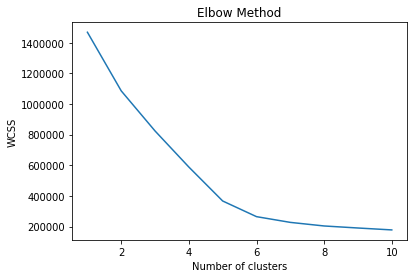

In [16]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = "k-means++", max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(cluster_dat.dropna())
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title("Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show()

In [17]:
kmeans5 = KMeans(n_clusters = 5, random_state = 0).fit(cluster_dat.dropna())                                                       

In [18]:
kmeans5.cluster_centers_

array([[-1.23471538e-01,  1.03230459e-01, -1.03411823e-01,
         1.79616292e+00, -1.10889618e-01],
       [-1.23035700e-01, -2.16067922e+00, -1.05345153e-01,
        -3.30608991e-01, -1.13105429e-01],
       [-6.34792384e-02, -1.49198419e-03,  5.56859907e+00,
        -2.48512037e-02,  6.15250176e+00],
       [-1.25600533e-01,  4.94794740e-01, -1.05418006e-01,
        -4.65800688e-01, -1.18615787e-01],
       [ 6.62804106e+00, -1.66348228e-02, -8.66887085e-02,
        -1.21936496e-03, -8.49158766e-02]])